-----------
Initializing structure...
time for choose_chunkdivision = 6.19888e-05 s
Working in 2D dimensions.
Computational cell is 0.1 x 4 x 0 with resolution 200
time for set_epsilon = 0.0168009 s
-----------


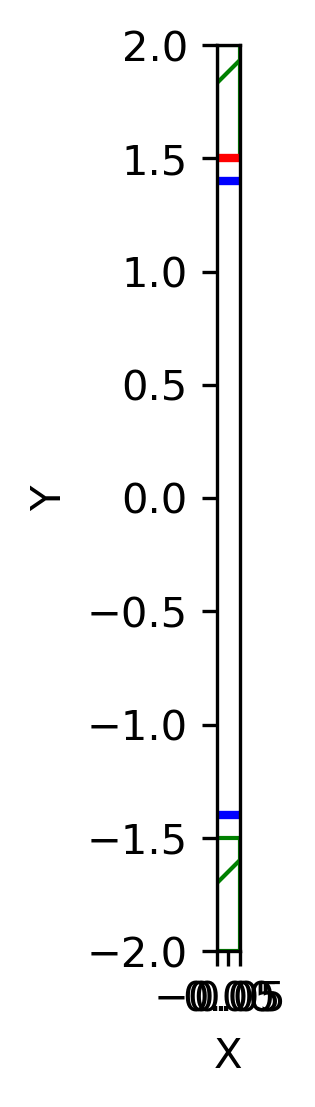

In [14]:
#Low-Threshold Nanolaser Based on Hybrid Plasmonic Waveguide Mode Supported by Metallic Grating Waveguide Structure
#based on https://pubs.acs.org/doi/10.1021/acsami.0c12525
#reflectance spectrum

import cmath
import math
import meep as mp
from meep.materials import Ag
import numpy as np
import matplotlib.pyplot as plt
P=0.1
W=0.084
tg=0.07
ns=1.5
celly=3

k_point=mp.Vector3(0,0,0)
cellx=P
dpml = 0.5  # thickness of PML layers
cell = mp.Vector3(cellx,celly+2*dpml,0)


pml_layers = [mp.PML(dpml,mp.Y)]
resolution = 200

wvl_min = 0.26
wvl_max = 0.8
fmin = 1/wvl_max
fmax = 1/wvl_min
fcen = 0.5*(fmax+fmin)
df = fmax-fmin
nfreq = 100
        
geometry =[mp.Block(size=mp.Vector3(W,tg,mp.inf),
                     center=mp.Vector3(0,0,0),
                     material=Ag),
          mp.Block(size=mp.Vector3(P,(celly-tg)/2+dpml),
                     center=mp.Vector3(0,(celly+tg+2*dpml)/4,0),
                     material=mp.Medium(index=ns))]

sources = [mp.Source(
        src=mp.GaussianSource(fcen, fwidth=df),
        component=mp.Ex,
        center=mp.Vector3(0,celly/2,0),
        size=mp.Vector3(cellx,0,0),
    )]

sim = mp.Simulation(
    cell_size=cell,
    sources=sources,
    boundary_layers=pml_layers,
    resolution=resolution,
    default_material=mp.Medium(index=ns),
    k_point=k_point
)

tran_fr = mp.FluxRegion(center=mp.Vector3(0,-celly/2+0.1,0),size=mp.Vector3(cellx,0,0))
tran = sim.add_flux(fcen, df, nfreq, tran_fr)
refl_fr = mp.FluxRegion(center=mp.Vector3(0,+celly/2-0.1,0),size=mp.Vector3(cellx,0,0))
refl = sim.add_flux(fcen, df, nfreq, refl_fr)

plt.figure(dpi=300)
sim.plot2D()
plt.show()

field decay(t = 50.0025): 0.2498128107023834 / 0.2498128107023834 = 1.0
on time step 37827 (time=94.5675), 0.000105745 s/step
field decay(t = 100.0025): 1.182366666280928e-16 / 0.2498128107023834 = 4.733010540798688e-16
run 0 finished at t = 100.0025 (40001 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.91278e-05 s
Working in 2D dimensions.
Computational cell is 0.1 x 4 x 0 with resolution 200
     block, center = (0,0,0)
          size (0.084,0.07,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.0175,0)
          size (0.1,1.965,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
time for set_epsilon = 0.029371 s
lorentzian susceptibility: frequency=16.365, gamma=1.95106
lorentzian susceptibility: frequency=7.32593, gamma=0.738804
lorentzian susceptibility: frequency=6.60165, gamma=0.052426
lorentzian susceptibi

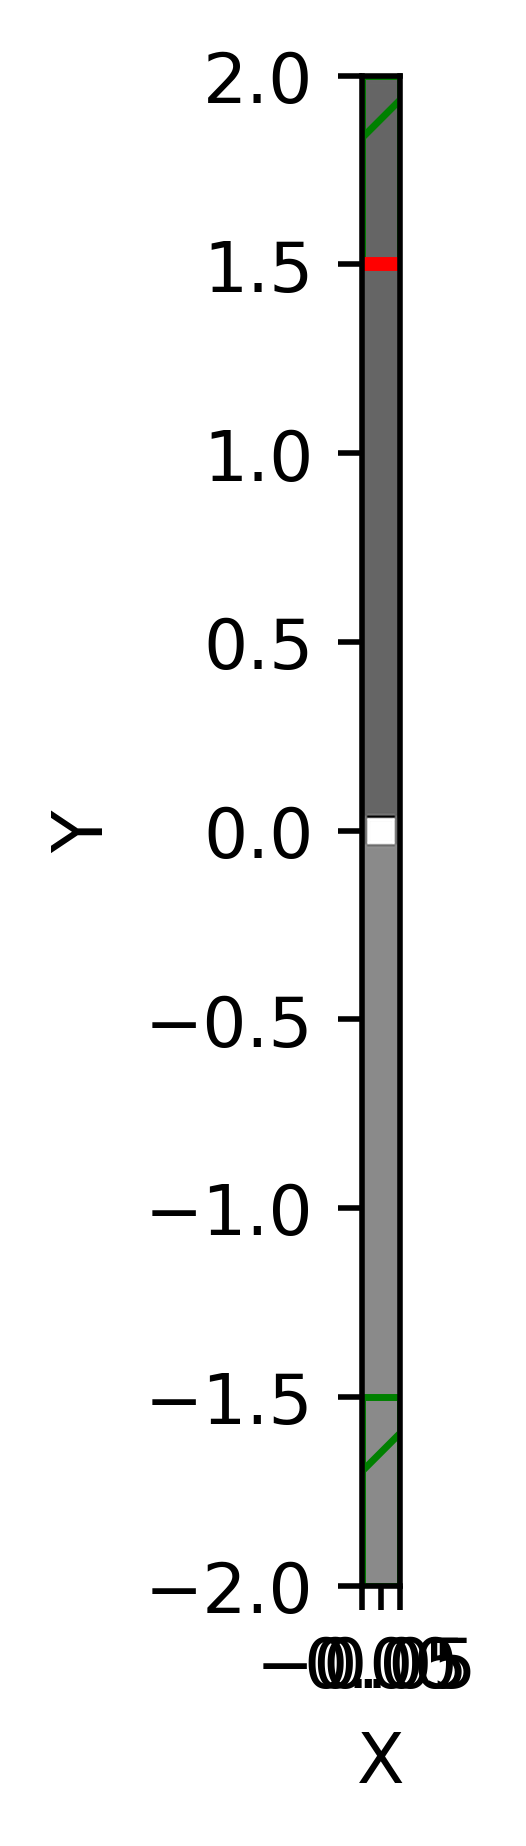

In [15]:
sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Hz, mp.Vector3(0,-celly/2,0), 1e-3))

empty_tran_flux = mp.get_fluxes(tran)
empty_tran_data = sim.get_flux_data(tran)
empty_refl_flux = mp.get_fluxes(refl)
empty_refl_data = sim.get_flux_data(refl)
sim.reset_meep()

sim = mp.Simulation(
    cell_size=cell,
    sources=sources,
    geometry=geometry,
    boundary_layers=pml_layers,
    resolution=resolution,
    default_material=mp.Medium(index=1),
    k_point=k_point
)
plt.figure(dpi=500)
sim.plot2D()
plt.show()

In [16]:
tran = sim.add_flux(fcen, df, nfreq, tran_fr)
#sim.load_minus_flux_data(tran, empty_tran_data)

refl = sim.add_flux(fcen, df, nfreq, refl_fr)
sim.load_minus_flux_data(refl, empty_refl_data)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Hz, mp.Vector3(0,-1.5,0), 1e-3))

refl_flux = mp.get_fluxes(refl)
R_meep = -1*np.divide(refl_flux,empty_refl_flux)
tran_flux = mp.get_fluxes(tran)
T_meep = 1*np.divide(tran_flux,empty_tran_flux)
freqs = mp.get_flux_freqs(refl)
wvls = np.divide(1,freqs)

on time step 12920 (time=32.3), 0.000309618 s/step
field decay(t = 50.0025): 0.008655580896668642 / 0.008655580896668642 = 1.0
on time step 25565 (time=63.9125), 0.000316353 s/step
on time step 38489 (time=96.2225), 0.000309508 s/step
field decay(t = 100.0025): 5.65595026954614e-17 / 0.008655580896668642 = 6.534454864517528e-15
run 0 finished at t = 100.0025 (40001 timesteps)


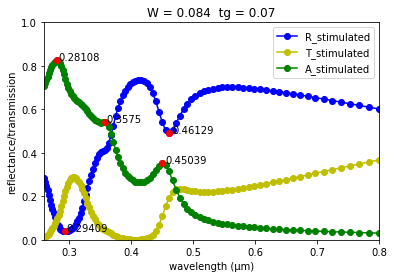

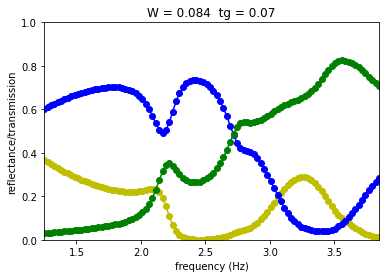

In [19]:
plt.figure()

A_meep=1-T_meep-R_meep

plt.xlabel("wavelength (μm)")
plt.ylabel("reflectance/transmission")
plt.plot(wvls,R_meep,'bo-',zorder=0,label="R_stimulated")
plt.plot(wvls,T_meep,'yo-',zorder=0,label="T_stimulated")
plt.plot(wvls,A_meep,'go-',zorder=0,label="A_stimulated")
for i in range(len(A_meep)-2):
    if A_meep[i]<A_meep[i+1] and A_meep[i+2]<A_meep[i+1]:
        plt.scatter(wvls[i+1],A_meep[i+1],color="r",zorder=8)
        plt.annotate(round(wvls[i+1],5),(wvls[i],A_meep[i+1]),zorder=10)
for i in range(len(R_meep)-2):
    if R_meep[i]>R_meep[i+1] and R_meep[i+2]>R_meep[i+1]:
        plt.scatter(wvls[i+1],R_meep[i+1],color="r",zorder=8)
        plt.annotate(round(wvls[i+1],5),(wvls[i],R_meep[i+1]),zorder=10)
plt.axis([np.min(wvls), np.max(wvls), 0,1])
plt.title("W = "+str(W)+'  tg = '+str(tg))
plt.legend()
plt.show()

plt.figure()

plt.xlabel("frequency (Hz)")
plt.ylabel("reflectance/transmission")
plt.plot(freqs,T_meep,'yo-',zorder=0,label="T_stimulated")
plt.plot(freqs,R_meep,'bo-',zorder=0,label="R_stimulated")
plt.plot(freqs,A_meep,'go-',zorder=0,label="A_stimulated")
plt.axis([np.min(freqs), np.max(freqs), 0,1])
plt.title("W = "+str(W)+'  tg = '+str(tg))
plt.show()

找模態

-----------
Initializing structure...
time for choose_chunkdivision = 6.29425e-05 s
Working in 2D dimensions.
Computational cell is 0.1 x 4 x 0 with resolution 200
     block, center = (0,0,0)
          size (0.084,0.07,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,1.0175,0)
          size (0.1,1.965,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
time for set_epsilon = 0.0354149 s
lorentzian susceptibility: frequency=16.365, gamma=1.95106
lorentzian susceptibility: frequency=7.32593, gamma=0.738804
lorentzian susceptibility: frequency=6.60165, gamma=0.052426
lorentzian susceptibility: frequency=3.61417, gamma=0.364563
lorentzian susceptibility: frequency=0.658148, gamma=3.13427
drude susceptibility: frequency=1e-10, gamma=0.0387146
-----------
Meep progress: 37.792500000000004/500.0 = 7.6% done in 4.0s, 48.9s to go
on time step 15117 (time=37

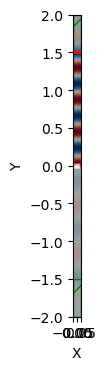

In [47]:
import cmath
import math
import meep as mp
from meep.materials import Ag
import numpy as np
import matplotlib.pyplot as plt
P=0.1
W=0.084
tg=0.07
n=1.5

grating_num=501
celly=3
cellx=P
wavelength=0.639

k_point=mp.Vector3(0,0,0)
dpml = 0.5  # thickness of PML layers
cell = mp.Vector3(cellx,celly+2*dpml,0)


pml_layers = [mp.PML(dpml,mp.Y)]
resolution = 200

fq=1/wavelength
        
geometry =[mp.Block(size=mp.Vector3(W,tg,mp.inf),
                     center=mp.Vector3(0,0,0),
                     material=Ag),
          mp.Block(size=mp.Vector3(P,(celly-tg)/2+dpml),
                     center=mp.Vector3(0,(celly+tg+2*dpml)/4,0),
                     material=mp.Medium(index=n))]

sources = [mp.Source(
        src=mp.ContinuousSource(fq),
        component=mp.Ex,
        center=mp.Vector3(0,celly/2,0),
        size=mp.Vector3(cellx,0,0),
    ),
           mp.Source(
        src=mp.ContinuousSource(fq),
        component=mp.Hz,
        center=mp.Vector3(0,celly/2,0),
        size=mp.Vector3(cellx,0,0),
    )
]

sim = mp.Simulation(
    cell_size=cell,
    sources=sources,
    geometry=geometry,
    boundary_layers=pml_layers,
    resolution=resolution,
    default_material=mp.Medium(index=1),
    k_point=k_point
)

t = 500  # run time
sim.run(mp.at_end(mp.output_efield_z), until=t)
plt.figure(dpi=100)
sim.plot2D(fields=mp.Hz)
plt.show()

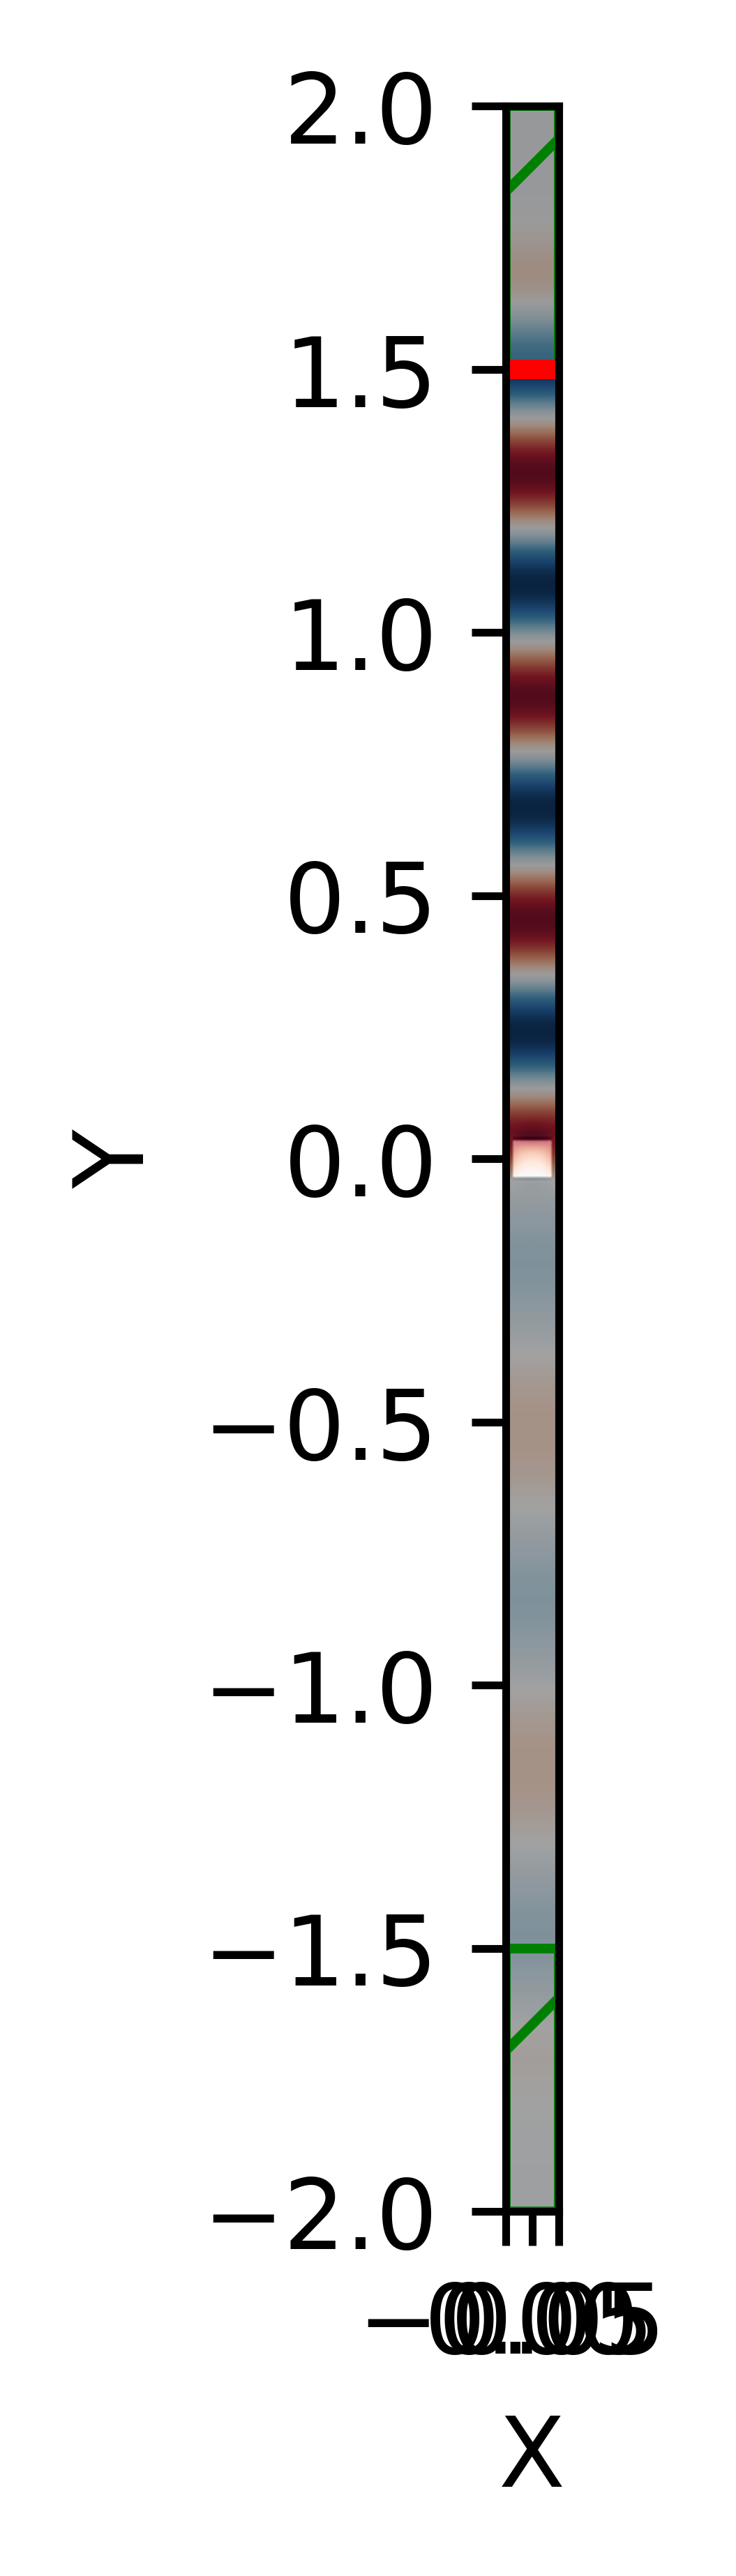

In [48]:
plt.figure(dpi=1000)
sim.plot2D(fields=mp.Hz)
plt.show()

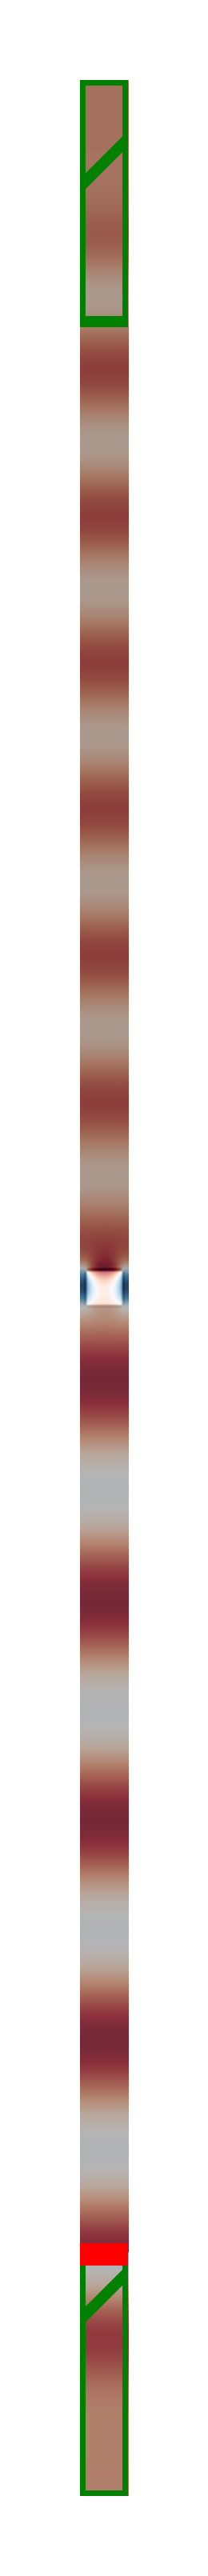

In [49]:
plt.figure(dpi=1000)
sim.plot2D(fields=mp.Hz)
plt.axis("off")
plt.show()

In [11]:
wvls

array([1.2       , 1.17534247, 1.15167785, 1.12894737, 1.10709677,
       1.08607595, 1.06583851, 1.04634146, 1.02754491, 1.00941176,
       0.99190751, 0.975     , 0.95865922, 0.94285714, 0.92756757,
       0.91276596, 0.89842932, 0.88453608, 0.87106599, 0.858     ,
       0.8453202 , 0.83300971, 0.82105263, 0.80943396, 0.79813953,
       0.78715596, 0.77647059, 0.76607143, 0.75594714, 0.74608696,
       0.73648069, 0.72711864, 0.71799163, 0.70909091, 0.70040816,
       0.69193548, 0.68366534, 0.67559055, 0.66770428, 0.66      ,
       0.65247148, 0.64511278, 0.63791822, 0.63088235, 0.624     ,
       0.61726619, 0.61067616, 0.60422535, 0.59790941, 0.59172414,
       0.58566553, 0.57972973, 0.57391304, 0.56821192, 0.56262295,
       0.55714286, 0.55176849, 0.54649682, 0.54132492, 0.53625   ,
       0.53126935, 0.52638037, 0.52158055, 0.51686747, 0.51223881,
       0.50769231, 0.50322581, 0.49883721, 0.4945245 , 0.49028571,
       0.48611898, 0.48202247, 0.47799443, 0.47403315, 0.47013